In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import laplacejumps as lj
from sklearn import metrics
from itertools import product

In [2]:
paper = True

In [87]:
microstructure_noise = False
poisson_jumps = False

In [88]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

if paper:
    presentation_fontsize = 16
else:
    presentation_fontsize = 22
    
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [89]:
k = 1
p = 2
theta = .5
infill_dim = int(24e3)
preaverage_dim = int(infill_dim**(11/20) * theta)
print(f"Preaverge_dim is {preaverage_dim}.")

if microstructure_noise:
    kappa_const = 1000
else:
    kappa_const = 50
    
kappa = int(kappa_const + infill_dim**(1/4))
print(f"Subsample_dim is {kappa}.")

time_dim = 250
jump_prop = .56

Preaverge_dim is 128.
Subsample_dim is 62.


vol_kappa = 1.4e-5
The variance = $(\theta * \omega^2 / 2 * \kappa)$

In [90]:
vol_kappa = 1
vol_theta = (.5 * 0.01)**2
vol_omega = 2.1e-3
vol_alpha = .5 # The curvature of thea vol-wrapping function, .5 = sqrt(), i.e. CIR

In [91]:
lj.__version__

'0.06.01-py37_0'

## Simulate the Data

In [92]:
if microstructure_noise and not poisson_jumps:
    log_rtn, vol_data = lj.simulate_log_rtn(kappa=vol_kappa, omega=vol_omega, theta=vol_theta, jumps=True, 
                                        diffusion=True, jump_theta=vol_theta, time_dim=time_dim, 
                                        infill_dim=int(infill_dim), noise_var=1e-10, noise_autocorr=.77)
elif not microstructure_noise and not poisson_jumps:
    log_rtn, vol_data = lj.simulate_log_rtn(kappa=vol_kappa, omega=vol_omega, theta=vol_theta, jumps=True, 
                                        diffusion=True, jump_theta=vol_theta, time_dim=time_dim, 
                                        infill_dim=int(infill_dim))
elif not microstructure_noise and poisson_jumps:
    log_rtn, vol_data = lj.simulate_log_rtn_rare_jumps(kappa=vol_kappa, omega=vol_omega, theta=vol_theta,
                                                    jump_prop=.5, jump_intensity=1, time_dim=time_dim,
                                                    infill_dim=int(infill_dim))
else:
     log_rtn, vol_data = lj.simulate_log_rtn_rare_jumps(kappa=vol_kappa, omega=vol_omega, theta=vol_theta,
                                                        jump_prop=.5, jump_intensity=1, time_dim=time_dim,
                                                        infill_dim=int(infill_dim), noise_var=1e-10, 
                                                        noise_autocorr=.77)

In [93]:
pd.concat([log_rtn, vol_data.applymap(np.sqrt)], axis=1).describe()

log_rtn   diffusion       jumps
count  6.0000e+06  6.0000e+06  6.0000e+06
mean  -9.3812e-09  4.9676e-03  4.8874e-03
std    4.5513e-05  7.8137e-04  7.6135e-04
min   -3.7299e-04  2.4799e-03  2.6050e-03
25%   -2.8452e-05  4.4208e-03  4.3315e-03
50%   -4.1787e-09  4.9488e-03  4.8521e-03
75%    2.8422e-05  5.4634e-03  5.4346e-03
max    4.1690e-04  7.7880e-03  7.4566e-03

In [94]:
vol_data['diffusion'].resample('D').sum().apply(np.sqrt).autocorr()

0.32051464496276816

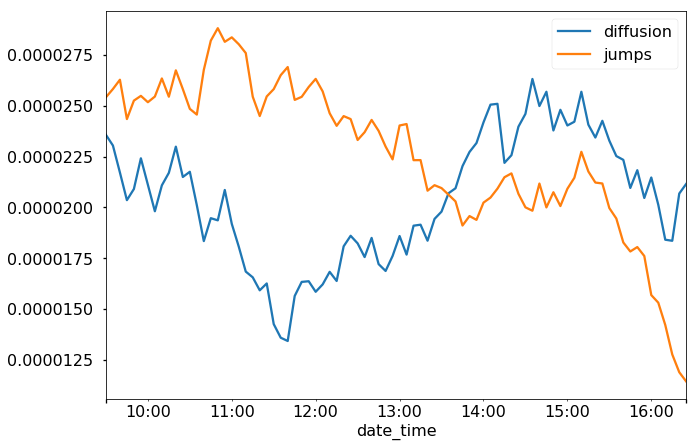

In [95]:
vol_data['2008-03-03'].resample('5min').last().plot()

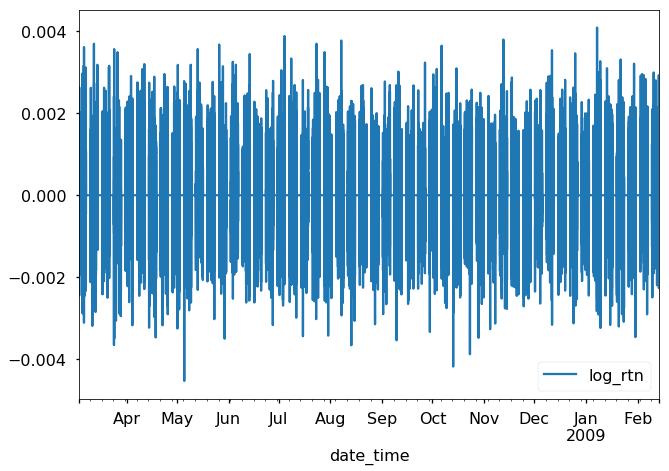

In [96]:
log_rtn.resample('10min').sum().dropna().plot()

## Deal with the Noise

In [97]:
if microstructure_noise:
    rtn = lj.preaverage_data(log_rtn, preaverage_dim=preaverage_dim)
else:
    rtn = log_rtn

In [98]:
noise_vol = log_rtn.groupby(pd.Grouper(freq='D')).apply(
    lambda x: lj.compute_noise_vol(x, preaverage_dim)).rename(
    columns={'log_price':'noise'}).dropna()

In [99]:
noise_vol.mean() * infill_dim

log_rtn    2.4857e-05
dtype: float64

## Instantaneous Estimates

In [100]:
local_vol_est = lj.compute_instantaneous_vol(rtn, infill_dim=infill_dim, kappa=kappa)

In [101]:
new_vol_data = pd.merge_asof(vol_data.resample('5min').last(), lj.mean_abs_vol_from_df(vol_data, kappa=kappa), 
                             left_index=True, right_index=True) 

In [102]:
new_vol_data.head()

diffusion       jumps  absolute
date_time                                            
2008-03-03 09:30:00  2.3567e-05  2.5413e-05    0.0055
2008-03-03 09:35:00  2.3042e-05  2.5816e-05    0.0054
2008-03-03 09:40:00  2.1718e-05  2.6273e-05    0.0054
2008-03-03 09:45:00  2.0360e-05  2.4342e-05    0.0053
2008-03-03 09:50:00  2.0906e-05  2.5248e-05    0.0052

In [103]:
local_comb_data = pd.merge_ordered(new_vol_data, local_vol_est, right_on=local_vol_est.index.name, 
                                   left_on=new_vol_data.index.name, suffixes=['_true', '_est']).set_index(
    'date_time').sort_index(axis=1).groupby(pd.Grouper(freq='5min')).mean().dropna()

In [104]:
local_comb_data.head()

absolute_est  absolute_true  diffusion_est  \
date_time                                                         
2008-03-03 09:30:00        0.0050         0.0055     2.5144e-05   
2008-03-03 09:35:00        0.0056         0.0054     2.9340e-05   
2008-03-03 09:40:00        0.0054         0.0054     1.2382e-05   
2008-03-03 09:45:00        0.0052         0.0053     1.6079e-05   
2008-03-03 09:50:00        0.0053         0.0052     2.7757e-05   

                     diffusion_true   jumps_est  jumps_true  
date_time                                                    
2008-03-03 09:30:00      2.3567e-05  1.5460e-05  2.5413e-05  
2008-03-03 09:35:00      2.3042e-05  2.2914e-05  2.5816e-05  
2008-03-03 09:40:00      2.1718e-05  4.1406e-05  2.6273e-05  
2008-03-03 09:45:00      2.0360e-05  3.0839e-05  2.4342e-05  
2008-03-03 09:50:00      2.0906e-05  1.8147e-05  2.5248e-05

In [105]:
column_names = set(local_vol_est.columns) - {'noise'}
rmse = [np.sqrt(metrics.mean_squared_error(y_true=local_comb_data[f"{name}_true"], 
                                           y_pred=local_comb_data[f"{name}_est"])) 
               / np.mean(np.abs(local_comb_data[f"{name}_true"]))
                    for name in sorted(column_names)]
mae = [metrics.mean_absolute_error(y_true=local_comb_data[f"{name}_true"],
                                   y_pred=local_comb_data[f"{name}_est"]) 
       / np.mean(np.abs(local_comb_data[f"{name}_true"]))
                    for name in sorted(column_names)]
pd.DataFrame(np.stack([rmse, mae]).T, index=sorted(column_names), columns=['RMSE', 'MAE'])

RMSE     MAE
absolute   0.0498  0.0396
diffusion  0.2836  0.2198
jumps      0.3608  0.2774

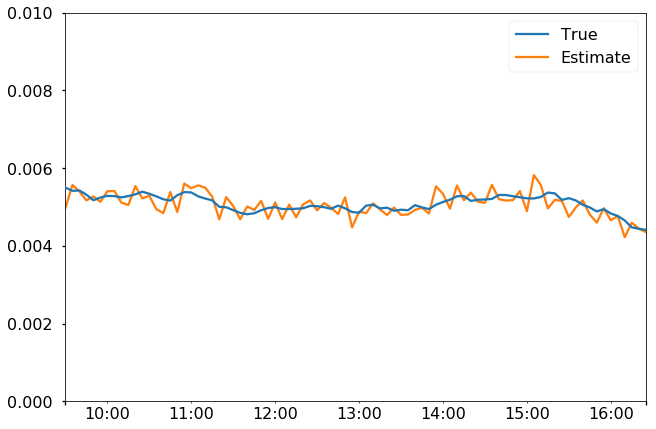

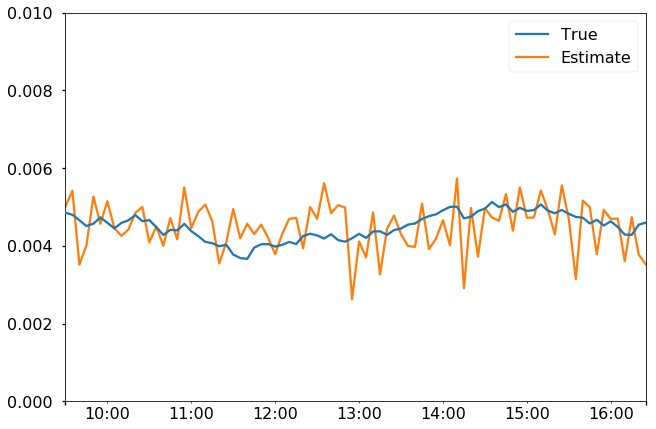

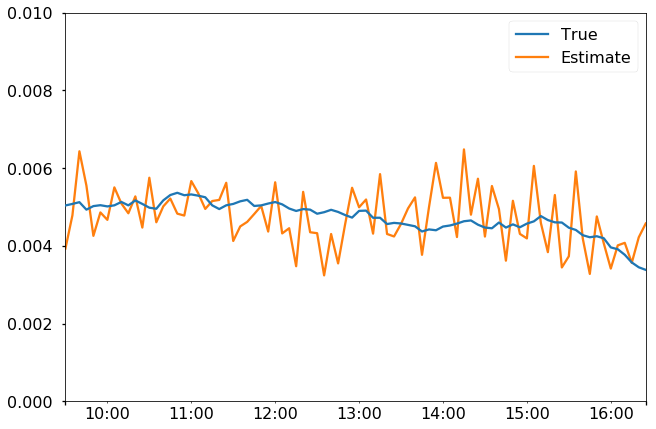

In [106]:
date = str(local_comb_data.index[0].date())
count = infill_dim // 1000
column_names = set(local_vol_est.columns) - {'noise'}

for name in sorted(column_names):
    fig, ax = mpl.pyplot.subplots()
    if 'absolute' in name:
        local_comb_data.loc[date, f'{name}_true'].plot(label='True', ax=ax, zorder=10)
        local_comb_data.loc[date, f'{name}_est'].plot(label='Estimate', ax=ax, zorder=0)
    else: 
        local_comb_data.loc[date, f'{name}_true'].transform(np.sqrt).plot(label='True', ax=ax, zorder=10)
        local_comb_data.loc[date, f'{name}_est'].transform(np.sqrt).plot(label='Estimate', ax=ax, zorder=0)
    ax.set_xlabel("")
    ax.legend()
    ax.set_ylim([0,0.01])

    if microstructure_noise:
        name = f'../doc/figures/cont_{name}_comparison_{count}k_with_micro.tmp.pdf'
    else:
        name = f'../doc/figures/cont_{name}_comparison_{count}k.tmp.pdf'
        
    fig.savefig(name, bbox_inches='tight', frameon=False, transparent=True)

# Compute the daily volatilities

In [107]:
discrete_vol_est = local_vol_est.resample('D').mean()

In [108]:
discrete_vol_data = vol_data.resample('D').mean()

In [109]:
discrete_vol_data.head()

diffusion       jumps
date_time                         
2008-03-03  2.0361e-05  2.2694e-05
2008-03-04  1.9008e-05  1.9612e-05
2008-03-05  2.3053e-05  2.5826e-05
2008-03-06  3.7000e-05  3.2045e-05
2008-03-07  2.9276e-05  3.0419e-05

In [110]:
discrete_vol_est.head()

absolute   diffusion       jumps
0                                           
2008-03-03    0.0051  2.0589e-05  2.2943e-05
2008-03-04    0.0048  2.0144e-05  1.9159e-05
2008-03-05    0.0054  2.2539e-05  2.7707e-05
2008-03-06    0.0064  3.4577e-05  3.5711e-05
2008-03-07    0.0060  2.8602e-05  3.2854e-05

In [111]:
bipower_vol = lj.bipower_for_df(rtn)

/home/sangrey/anaconda3/lib/python3.7/site-packages/laplacejumps/vol_estimation.py:83: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  bipower_vol.clip_lower(0, inplace=True)


In [112]:
bipower_vol.head()

quad  noise   diffusion       jumps
date_time                                            
2008-03-03  4.2874e-05      0  4.0150e-05  2.7236e-06
2008-03-04  3.8649e-05      0  3.6912e-05  1.7367e-06
2008-03-05  4.8896e-05      0  4.6198e-05  2.6979e-06
2008-03-06  6.8209e-05      0  6.4804e-05  3.4052e-06
2008-03-07  5.9561e-05      0  5.6560e-05  3.0016e-06

In [113]:
jump_regressions = lj.jump_regressions_estimator(pd.DataFrame(rtn))

In [114]:
discrete_vol = pd.merge(discrete_vol_est, bipower_vol, left_index=True, right_index=True,
                             suffixes=('_trunc', '_bipower'))
discrete_vol['jumps_jump_reg'] = jump_regressions['jumps']
discrete_vol['diffusion_jump_reg'] = jump_regressions['diffusion']
discrete_vol['real_vol'] = rtn.groupby(pd.Grouper(freq='D')).agg(lj.real_vol)
discrete_comb_data = pd.concat([discrete_vol_data, discrete_vol], axis=1)

## Compute the 5 Minute Bipower variations

In [115]:
real_vol = log_rtn.resample('5min').sum().groupby(pd.Grouper(freq='D')).agg(lj.real_vol)
discrete_comb_data['diffusion_5min'] = log_rtn.resample('5min').sum().groupby(pd.Grouper(freq='D')).agg(
    lambda x: lj.bipower(x, 1,1,1))
discrete_comb_data['jumps_5min'] = (real_vol.T - discrete_comb_data.diffusion_5min).clip_lower(0).T
discrete_comb_data.dropna(inplace=True)

/home/sangrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


# Plot the Results

In [116]:
discrete_comb_data.head()

diffusion       jumps  absolute  diffusion_trunc  jumps_trunc  \
date_time                                                                    
2008-03-03  2.0361e-05  2.2694e-05    0.0051       2.0589e-05   2.2943e-05   
2008-03-04  1.9008e-05  1.9612e-05    0.0048       2.0144e-05   1.9159e-05   
2008-03-05  2.3053e-05  2.5826e-05    0.0054       2.2539e-05   2.7707e-05   
2008-03-06  3.7000e-05  3.2045e-05    0.0064       3.4577e-05   3.5711e-05   
2008-03-07  2.9276e-05  3.0419e-05    0.0060       2.8602e-05   3.2854e-05   

                  quad  noise  diffusion_bipower  jumps_bipower  \
date_time                                                         
2008-03-03  4.2874e-05      0         4.0150e-05     2.7236e-06   
2008-03-04  3.8649e-05      0         3.6912e-05     1.7367e-06   
2008-03-05  4.8896e-05      0         4.6198e-05     2.6979e-06   
2008-03-06  6.8209e-05      0         6.4804e-05     3.4052e-06   
2008-03-07  5.9561e-05      0         5.6560e-05     3.0016e-06   

            jumps_jump_reg  diffusion_jump_reg    real_vol  diffusion_5min  \
date_time                                                                    
2008-03-03             0.0          3.9654e-05  4.2874e-05      5.6294e-05   
2008-03-04             0.0          3.6348e-05  3.8649e-05      3.6708e-05   
2008-03-05             0.0          4.5871e-05  4.8896e-05      6.1749e-05   
2008-03-06             0.0          6.3898e-05  6.8209e-05      7.9652e-05   
2008-03-07             0.0          5.5635e-05  5.9561e-05      4.4031e-05   

            jumps_5min  
date_time               
2008-03-03  0.0000e+00  
2008-03-04  0.0000e+00  
2008-03-05  3.9778e-07  
2008-03-06  0.0000e+00  
2008-03-07  5.0978e-06

In [130]:
microstructure_noise

False

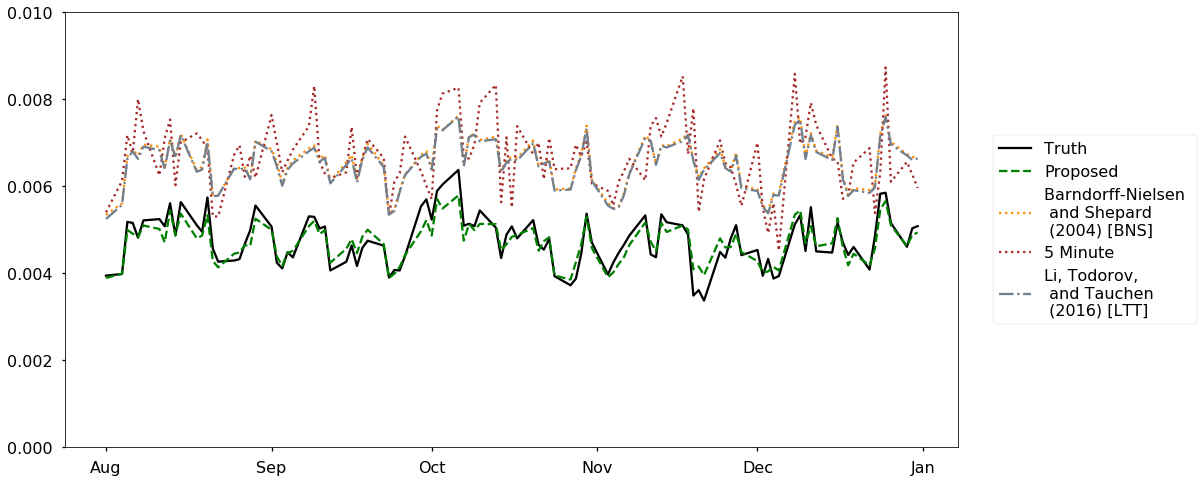

In [131]:
discrete_diffusion_compare_fig, discrete_diffusion_compare_ax = mpl.pyplot.subplots()
discrete_diffusion_compare_fig.set_size_inches((16, 8))
start_date, end_date = '2008-08', '2008-12'
true_diff_data = discrete_comb_data.loc[start_date:end_date,'diffusion'].transform(np.sqrt).replace(
    0, np.nan).dropna()
discrete_diffusion_compare_ax.plot(true_diff_data, label='Truth', color='black', linestyle='-')

trunc_diff_est = discrete_comb_data.loc[start_date:end_date,'diffusion_trunc'].transform(np.sqrt).dropna()
discrete_diffusion_compare_ax.plot(trunc_diff_est, label='Proposed', color='green', linestyle='--')

bipower_diff_est = discrete_comb_data.loc[start_date:end_date,'diffusion_bipower'].transform(np.sqrt).dropna()
discrete_diffusion_compare_ax.plot(bipower_diff_est, label='Barndorff-Nielsen \n and Shepard \n (2004) [BNS]', color='darkorange', linestyle=':')

diff_5min_est = discrete_comb_data.loc[start_date:end_date,'diffusion_5min'].transform(np.sqrt).dropna()
discrete_diffusion_compare_ax.plot(diff_5min_est, label='5 Minute', color='brown', linestyle=':')

count = str(infill_dim // 1000)
discrete_diffusion_compare_ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator(maxticks=6))
discrete_diffusion_compare_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
discrete_diffusion_compare_ax.set_ylim([0, 0.01])

ecta_est = discrete_comb_data.loc[start_date:end_date,'diffusion_jump_reg'].apply(np.sqrt).dropna()
discrete_diffusion_compare_ax.plot(ecta_est, color='slategrey', label='Li, Todorov, \n and Tauchen \n (2016) [LTT]', linestyle='-.')

discrete_diffusion_compare_ax.legend(loc='center left', bbox_to_anchor=(1.03,.5))

if not poisson_jumps:

    if microstructure_noise and paper:
        figure_name =  f"""../doc/figures/daily_diffusion_comp_{count}k_with_Li_micro.tmp.pdf""" 
    elif microstructure_noise and not paper:
        figure_name =  f"""../doc/figures/daily_diffusion_comp_{count}k_with_Li_micro_present.tmp.pdf""" 
    elif paper and not microstructure_noise:
        figure_name =  f"""../doc/figures/daily_diffusion_comp_{count}k_with_Li.tmp.pdf""" 
    else:
        figure_name =  f"""../doc/figures/daily_diffusion_comp_{count}k_with_Li_present.tmp.pdf""" 
else:
    figure_name =  f"""../doc/figures/daily_diffusion_poisson_{count}k_with_Li_present.tmp.pdf""" 
    
discrete_diffusion_compare_fig.savefig(figure_name, bbox_inches='tight', frameon=False, transparent=True)

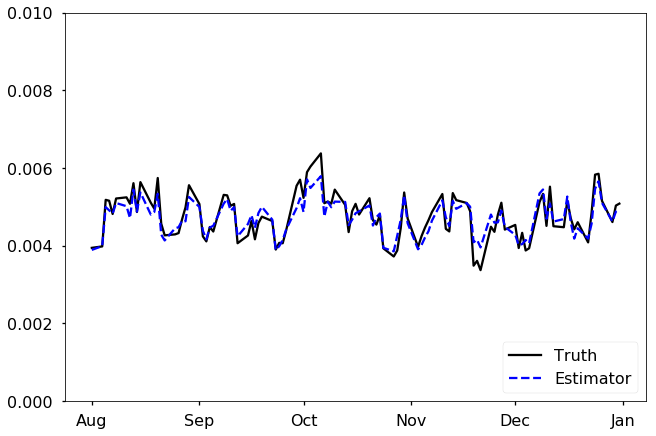

In [118]:
discrete_diffusion_compare_fig, discrete_diffusion_compare_ax = mpl.pyplot.subplots()
start_date, end_date = '2008-08', '2008-12'
true_diff_data = discrete_comb_data.loc[start_date:end_date,'diffusion'].transform(np.sqrt).replace(
    0, np.nan).dropna()
discrete_diffusion_compare_ax.plot(true_diff_data, label='Truth', color='black', linestyle='-')

trunc_diff_est = discrete_comb_data.loc[start_date:end_date,'diffusion_trunc'].transform(np.sqrt).dropna()
discrete_diffusion_compare_ax.plot(trunc_diff_est, label='Estimator', color='blue', linestyle='--')
discrete_diffusion_compare_ax.set_ylim([0, 0.01])

discrete_diffusion_compare_ax.legend(loc='lower right')
count = str(infill_dim // 1000)
discrete_diffusion_compare_ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator(maxticks=6))
discrete_diffusion_compare_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

discrete_diffusion_compare_fig.savefig('../doc/figures/discrete_diffusion_comparison_' + count
                                       + 'k_trunc.tmp.pdf', bbox_inches='tight', frameon=False, transparent=True)

In [119]:
discrete_comb_data.loc[start_date:end_date,'jumps_5min'].apply(np.sqrt).describe()

count    109.0000
mean       0.0009
std        0.0010
min        0.0000
25%        0.0000
50%        0.0006
75%        0.0018
max        0.0032
Name: jumps_5min, dtype: float64

In [129]:
figure_name

'../doc/figures/daily_jump_comp_24k_with_Li.tmp.pdf'

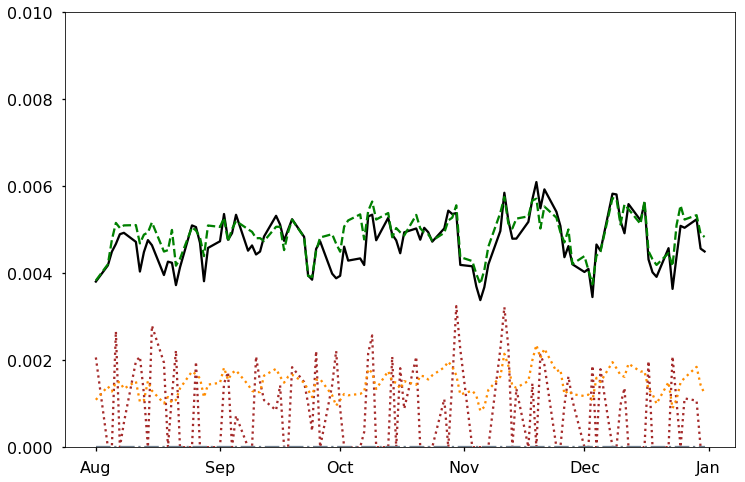

In [132]:
discrete_jumps_compare_fig2, discrete_jumps_compare_ax2 = mpl.pyplot.subplots()
discrete_jumps_compare_fig2.set_size_inches((12, 8))
start_date, end_date = '2008-08', '2008-12'
true_jump_data = discrete_comb_data.loc[start_date:end_date,'jumps'].transform(
    np.sqrt).replace(0, np.nan).dropna()
discrete_jumps_compare_ax2.plot(true_jump_data, label='Truth', color='black', linestyle='-')
trunc_est_data = discrete_comb_data.loc[start_date:end_date,'jumps_trunc'].transform(np.sqrt).dropna()
discrete_jumps_compare_ax2.plot(trunc_est_data, label='Estimator', color='green', linestyle='--')

jump_5min_est = discrete_comb_data.loc[start_date:end_date,'jumps_5min'].transform(np.sqrt).dropna()
discrete_jumps_compare_ax2.plot(jump_5min_est, label='5 Minute', color='brown', linestyle=':')

bipower_jumps_est = discrete_comb_data.loc[start_date:end_date,'jumps_bipower'].transform(np.sqrt).dropna()
discrete_jumps_compare_ax2.plot(bipower_jumps_est, label='Bipower', color='darkorange', linestyle=':')

count = str(infill_dim // 1000)

discrete_jumps_compare_ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(maxticks=6))
discrete_jumps_compare_ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))


ecta_est = discrete_comb_data.loc[start_date:end_date,'jumps_jump_reg'].apply(np.sqrt).dropna()
discrete_jumps_compare_ax2.plot(ecta_est, color='slategrey', label='LTT', linestyle='-.')
discrete_jumps_compare_ax2.set_ylim([0, 0.01])

if not poisson_jumps:

    if microstructure_noise and paper:
        figure_name =  f"""../doc/figures/daily_jump_comp_{count}k_with_Li_micro.tmp.pdf""" 
    elif microstructure_noise and not paper:
        figure_name =  f"""../doc/figures/daily_jump_comp_{count}k_with_Li_micro_present.tmp.pdf""" 
    elif paper and not microstructure_noise:
        figure_name =  f"""../doc/figures/daily_jump_comp_{count}k_with_Li.tmp.pdf""" 
    else:
        figure_name =  f"""../doc/figures/daily_jump_comp_{count}k_with_Li_present.tmp.pdf""" 
else:
    figure_name = f"""../doc/figures/daily_jump_poisson_{count}k_with_Li_present.tmp.pdf""" 

discrete_jumps_compare_fig2.savefig(figure_name, bbox_inches='tight', frameon=False, transparent=True)

In [121]:
figure_name

'../doc/figures/daily_jump_comp_24k_with_Li.tmp.pdf'

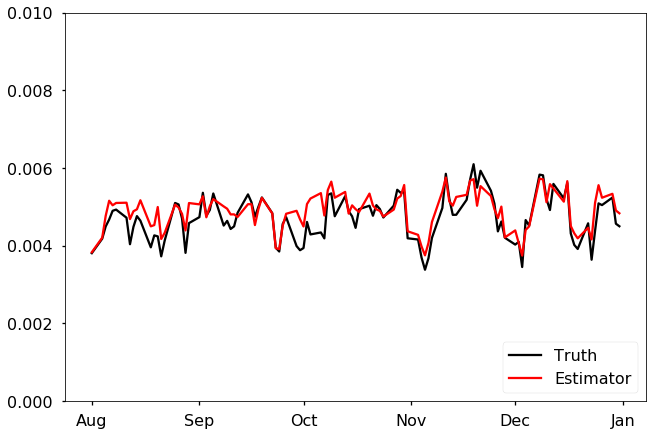

In [122]:
discrete_jumps_compare_fig, discrete_jumps_compare_ax = mpl.pyplot.subplots()

start_date, end_date = '2008-08', '2008-12'
true_jump_data = discrete_comb_data.loc[start_date:end_date,'jumps'].transform(
    np.sqrt).replace(0, np.nan).dropna()
discrete_jumps_compare_ax.plot(true_jump_data, label='Truth', color='black')
trunc_est_data = discrete_comb_data.loc[start_date:end_date,'jumps_trunc'].transform(np.sqrt).dropna()
discrete_jumps_compare_ax.plot(trunc_est_data, label='Estimator', color='red')

discrete_jumps_compare_ax.set_ylim([0, 0.01])
discrete_jumps_compare_ax.legend(loc='lower right')
count = str(infill_dim // 1000)

discrete_jumps_compare_ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator(maxticks=6))
discrete_jumps_compare_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

discrete_jumps_compare_fig.savefig('../doc/figures/discrete_jumps_comparison_' + count + 'k_trunc.tmp.pdf',
                                   bbox_inches='tight', frameon=False, transparent=True)

In [123]:
discrete_comb_data['diffusion_trunc'].describe()

count    2.5000e+02
mean     2.4507e-05
std      5.3170e-06
min      1.4866e-05
25%      2.0533e-05
50%      2.3932e-05
75%      2.7869e-05
max      4.3116e-05
Name: diffusion_trunc, dtype: float64

## Compute the Relative errors

In [124]:
column_names = ['bipower', 'trunc', 'jump_reg', '5min']
               
vol_names = ['diffusion', 'jumps']
rmse = {vol_name + "_" + col_name : np.sqrt(metrics.mean_squared_error(
    y_true=discrete_comb_data[vol_name].apply(np.sqrt).dropna(), 
    y_pred=discrete_comb_data[f"{vol_name}_{col_name}"].apply(np.sqrt).dropna())) 
                    for col_name, vol_name in product(sorted(column_names), vol_names)}
mae = {vol_name + "_" + col_name  : metrics.mean_absolute_error(y_true=discrete_comb_data[
    vol_name].apply(np.sqrt).dropna(),y_pred=discrete_comb_data[
    vol_name + "_" + col_name].apply(np.sqrt).dropna()) 
                    for col_name, vol_name in product(sorted(column_names), vol_names)}
mean_error = pd.concat([pd.DataFrame.from_dict(rmse, orient='index').rename(columns={0: 'RMSE'}), 
                        pd.DataFrame.from_dict(mae, orient='index').rename(columns={0: 'MAE'})], axis=1)

In [125]:
(mean_error.loc[[f'diffusion_{name}' for name in column_names]] 
 / discrete_comb_data['diffusion'].apply(np.sqrt).mean())

RMSE     MAE
diffusion_bipower   0.3834  0.3731
diffusion_trunc     0.0541  0.0439
diffusion_jump_reg  0.3740  0.3636
diffusion_5min      0.4217  0.3936

In [126]:
(mean_error.loc[[f'jumps_{name}' for name in column_names]] 
 / discrete_comb_data['jumps'].apply(np.sqrt).mean())

RMSE     MAE
jumps_bipower   0.6902  0.6859
jumps_trunc     0.0835  0.0635
jumps_jump_reg  1.0089  1.0000
jumps_5min      0.8322  0.7972